Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 23-June-2025

In [58]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import itertools
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [36]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/Connectomics/'
syn_thresh = 5

In [39]:
# Load connections
df_connectivity = pd.read_csv(data_dir+'manc_v121_connections.csv')

# Load classifications
df_class = pd.read_csv(data_dir+'manc_v121_classifications.csv')

# Rename columns for consistency with FlyWire dataset
df_connectivity = df_connectivity.rename(columns={"bodyId_pre": "pre_root_id", "bodyId_post": "post_root_id", "weight": "syn_count"}, errors="raise")

df_class = df_class.rename(columns={"bodyId": "root_id", 
                                    "class": "super_class", 
                                    "predictedNt": "nt_type",
                                    "predictedNtProb": "nt_type_score"}, 
                           errors="raise")

In [65]:
# Set source neurons
dict_ids = {}
dict_ids['DNg55'] = [14904] 
dict_ids['DNge048'] = [11856, 12025]
dict_ids['DNge053'] = [13184, 13291]
dict_ids['DNp68'] = [14585, 15134]
dict_ids['DNpe053'] = [15016, 14999]
dict_ids['DNpe020'] = [20978, 21696, 22586, 26296]
dict_ids['DNp52'] = [151717]
dict_ids['DNpe042'] = [21069,190167]
dict_ids['DNd05'] = [13238, 12898]
dict_ids['DNge150'] = [12613, 13548]
dict_ids['DNge050'] = [10279, 11120]
dict_ids['DNp64'] = [17113, 17467]

source_ids = list(itertools.chain(*list(dict_ids.values())))

In [82]:
# Get unique neuron names
neuron_names = list(dict_ids.keys())

In [83]:
# Get number of output synapses per neuropil
dict_synapses = {}

for source_id in source_ids:
    df_coonectivity_post = df_connectivity[df_connectivity.pre_root_id == source_id]

    # Remove (L) and (R) designation
    roi_updated = []
    for roi in df_coonectivity_post.roi.tolist():
        if '(R)' in roi or '(L)' in roi:
            roi_updated.append(roi[0:len(roi)-3])
        else:
            roi_updated.append(roi)
    df_coonectivity_post['roi'] = roi_updated
    
    # Sum synapses for each roi
    df_coonectivity_post = df_coonectivity_post.groupby(['roi'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

    rel_syn_count = df_coonectivity_post.syn_count.sum().item()

    dict_synapses[source_id] = {}
    for index, row in df_coonectivity_post.iterrows():
        dict_synapses[source_id][row.roi] = row.syn_count/rel_syn_count

In [84]:
# Get unique neuropils
neuropils = []
for source_id in dict_synapses.keys():
    neuropils.append(list(dict_synapses[source_id].keys()))
neuropils = list(np.unique(list(itertools.chain(*neuropils))))

In [85]:
# Compute connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(neuropils)))

for source_index, source_id in enumerate(dict_synapses.keys()):
    for neuropil in dict_synapses[source_id].keys():
        weight = dict_synapses[source_id][neuropil]
        neuropil_index = neuropils.index(neuropil)
        connectivity_matrix[source_index, neuropil_index] = weight

In [86]:
# Average rows for the same source neuron type
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(dict_ids.keys()):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

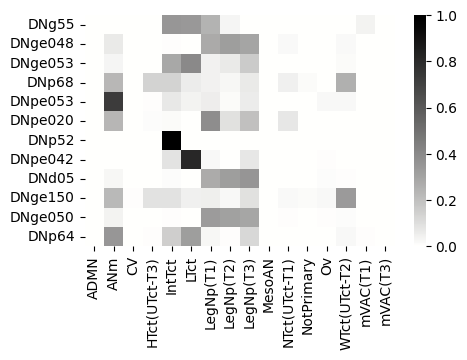

In [87]:
# Plot connectivity matrix
fig, ax = plt.subplots(figsize=(5,3))  
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix, 
            xticklabels = neuropils, 
            yticklabels = neuron_names,
            cmap = cmap)
plt.show()

In [88]:
# Remove nerves 
nerves = ['ADMN','CV','MesoAN','NotPrimary']
columns_to_delete = [index for index, neuropil in enumerate(neuropils) if neuropil in nerves]
connectivity_matrix = np.delete(connectivity_matrix, columns_to_delete, 1)
neuropils = [neuropil for neuropil in neuropils if neuropil not in nerves]

# Sort neuropils 
sort_list = ['LegNp(T1)','LegNp(T2)','LegNp(T3)','Ov','mVAC(T1)','mVAC(T3)','LTct','IntTct','NTct(UTct-T1)','WTct(UTct-T2)','HTct(UTct-T3)','ANm']
sort_index = [neuropils.index(neuropil) for neuropil in sort_list]
connectivity_matrix = connectivity_matrix[:,sort_index]
neuropils = [neuropils[index] for index in sort_index]

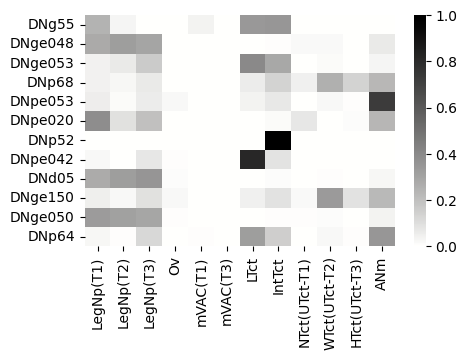

In [89]:
# Plot connectivity matrix
fig, ax = plt.subplots(figsize=(5,3))  
cmap = cmocean.cm.gray_r
yticklabels = list(dict_ids.keys())

sns.heatmap(connectivity_matrix, 
            xticklabels = neuropils, 
            yticklabels = neuron_names,
            cmap = cmap)
plt.show()

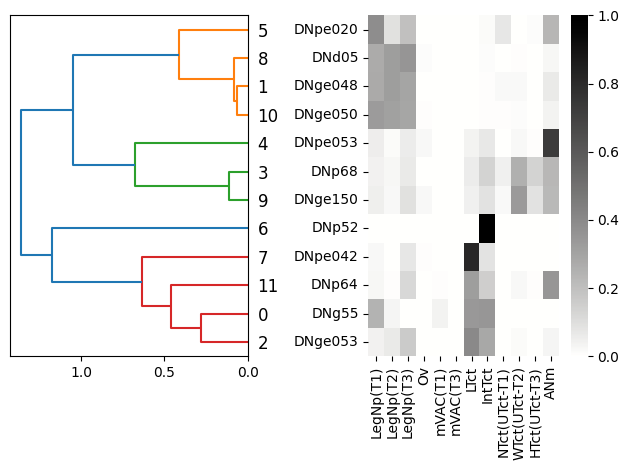

In [90]:
# Cluster rows of connectivity matrix using hierarchical clustering
# Note: Clusters may vary depending on whether clustering is based on absolute or relative synapse numbers

# Compute linkage matrix
Z = linkage(connectivity_matrix, method='ward')  

# Plot dendrogram 
fig, [ax1, ax2] = plt.subplots(1,2)
d = dendrogram(Z, orientation='left', ax=ax1, color_threshold=0.7) 
plt.tight_layout()
ymin, ymax = ax1.get_ylim()
ax1.set_ylim(ymax, ymin)

# Get ordered row indices  
sort_index = d['leaves']

# Sort connectivity matrix and labels
connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
neuron_names = [neuron_names[i] for i in sort_index]

# Plot clustered connectivity matrix
sns.heatmap(connectivity_matrix, 
            xticklabels = neuropils, 
            yticklabels = neuron_names,
            cmap = cmap,
            ax = ax2)
plt.tight_layout()
#plt.savefig(r"C:\Users\Chris\Desktop\clustered_connectivity_matrix.eps", bbox_inches="tight", transparent=True)
plt.show()

In [91]:
# Compute mean output per neuropil per cluster
clusters = [[0,1,2,3], [4,5,6], [8,9,10,11]]
cluster_means = np.zeros((len(clusters),len(neuropils)))
for cluster_index, cluster in enumerate(clusters):
    cluster_means[cluster_index,:] = np.mean(connectivity_matrix[cluster,:],axis=0)

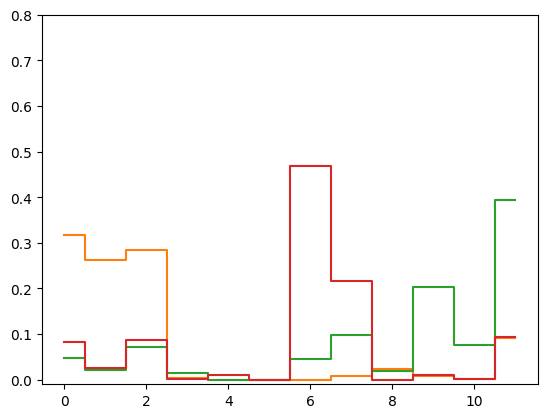

In [93]:
# Plot means
colors = ['tab:orange','tab:green','tab:red']
for cluster_index, _ in enumerate(clusters):
    plt.step(range(len(cluster_means[cluster_index,:])),cluster_means[cluster_index,:], color=colors[cluster_index], where='mid')

plt.ylim([-0.01,0.8])
#plt.savefig(r"C:\Users\Chris\Desktop\cluster_means.eps", bbox_inches="tight", transparent=True)
plt.show()